# Setup

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import log_with_inf_noise_addition, computation_times
from src.python.visualization import plot_approximations, plot_computation_times

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Load data

In [3]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2022_12_02_BF_BS'
NN_fixed_file = '2022_12_02_BF_NNa'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))

In [4]:
NN_fixed

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.964281,0.035719,0,0.037042,1182.864466,0.004911,0.557
1,2,0,0.965821,0.034179,0,0.035388,1182.864466,0.004911,0.557
2,3,0,0.991281,0.008719,0,0.008796,1182.864466,0.004911,0.557
3,4,1,0.412878,0.587122,1,1.422026,1182.864466,0.004911,0.557
4,5,0,0.965792,0.034208,0,0.035419,1182.864466,0.004911,0.557
...,...,...,...,...,...,...,...,...,...
95,96,0,0.971936,0.028064,0,0.028874,1182.864466,0.004911,0.557
96,97,0,0.430513,0.569487,1,1.322811,1182.864466,0.004911,0.557
97,98,1,0.015731,0.984269,1,62.567156,1182.864466,0.004911,0.557
98,99,1,0.022459,0.977541,1,43.525284,1182.864466,0.004911,0.557


# Calculate performance metrics

In [5]:
n_bootstrap = 100000
names = ['Bridge sampling', 'Fixed network', 'Variable network']
metrics = ['Accuracy', 'ROC AUC', 'MAE', 'RMSE', 'Log score', 'Bias']

# Calculate performance metrics
perf_metrics = performance_metrics(bridge, NN_fixed, NN_fixed, names=names, metrics=metrics)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(bridge, NN_fixed, NN_fixed, 100, names=names, metrics=metrics)

In [6]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.95,0.9852,0.095463,0.218608,0.154887,-0.006345
Fixed network,0.92,0.9728,0.144570,0.252839,0.205741,0.007591
Variable network,0.92,0.9728,0.144570,0.252839,0.205741,0.007591


In [7]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.9536,0.986482,0.092659,0.209985,0.147212,-0.008629
Fixed network,0.9199,0.973589,0.142163,0.248350,0.201992,0.004899
Variable network,0.9199,0.973589,0.142163,0.248350,0.201992,0.004899


In [8]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.022294,0.009283,0.020153,0.034718,0.041498,0.020268
Fixed network,0.026589,0.013160,0.021515,0.029836,0.038400,0.026057
Variable network,0.026589,0.013160,0.021515,0.029836,0.038400,0.026057


In [9]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop('MAE', axis=1) # drop MAE column as results do not add much information
metrics_ses = metrics_ses.round(2).drop('MAE', axis=1) # drop MAE column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row,col] = f'{metrics_means.iloc[row,col]}' + f' ({metrics_ses.iloc[row,col]})'

print(metrics_means.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & ROC AUC & RMSE & Log score & Bias \\
\midrule
Bridge sampling & 0.95 (0.02) & 0.99 (0.01) & 0.21 (0.03) & 0.15 (0.04) & -0.01 (0.02) \\
Fixed network & 0.92 (0.03) & 0.97 (0.01) & 0.25 (0.03) & 0.2 (0.04) & 0.0 (0.03) \\
Variable network & 0.92 (0.03) & 0.97 (0.01) & 0.25 (0.03) & 0.2 (0.04) & 0.0 (0.03) \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.51
NN fixed proportion = 0.54


# Plot PMPs & log BFs

In [11]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)

## BS vs fixed NN

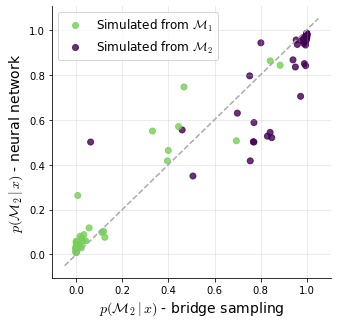

In [12]:
# PMPs
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', NN_name='neural network', save=False)

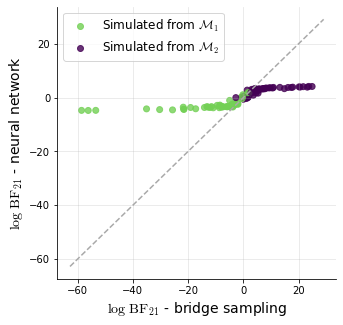

In [13]:
# Log BFs
plot_approximations(bridge, NN_fixed, approximated_outcome='Log BFs', NN_name='neural network')

# of included datasets: 75


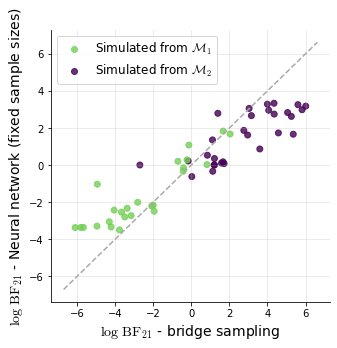

In [14]:
# Log Bfs with filter
filter_high = bridge['bayes_factor']<1000
filter_low = bridge['bayes_factor']>0.001
bridge_filtered = bridge[filter_high & filter_low].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter_high & filter_low].reset_index(drop=True)
print('# of included datasets: {}'.format(min([sum(filter_high), sum(filter_low)])))

plot_approximations(bridge_filtered, NN_fixed_filtered, approximated_outcome='Log BFs', NN_name='Neural network (fixed sample sizes)', save=False)

# Plot together for publication

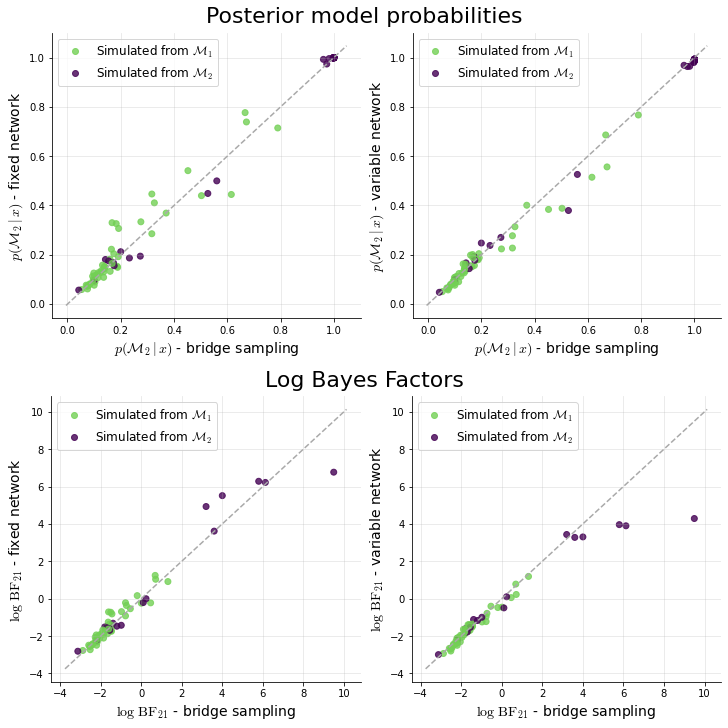

In [17]:
# Plot with PMP/log BF suptitles

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigure_titles = ['Posterior model probabilities', 'Log Bayes Factors']

bridge_list = [bridge, bridge_filtered]
NN_fixed_list = [NN_fixed, NN_fixed_filtered]
NN_variable_list = [NN_variable, NN_variable_filtered]

outcomes = ['PMPs', 'Log BFs']

# Use subfig to enable row titles
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    plot_approximations(bridge_list[row], NN_fixed_list[row], approximated_outcome=outcomes[row], NN_name='fixed network', ax=axs[0])
    plot_approximations(bridge_list[row], NN_variable_list[row], approximated_outcome=outcomes[row], NN_name='variable network', ax=axs[1])

plt.savefig('bs_comparison_convergence.png', dpi=300, bbox_inches='tight')

# Find biggest discrepancies and compare implications

In [18]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

In [19]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN fixed: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 61046338415.1287
BF NN fixed: 0.0473293017469533


In [40]:
bridge["divergences"] = abs(bridge["m1_prob"] - NN_fixed["m1_prob"])
NN_fixed["divergences"] = abs(bridge["m1_prob"] - NN_fixed["m1_prob"])
bridge.sort_values("divergences", ascending=False)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,m0_bridge_error,m1_bridge_error,compile_time,stan_time,bridge_time,divergences
79,80,1,1.638100e-11,1.000000e+00,1,6.104634e+10,0%,1%,48.025295,316.420995,68.337192,0.954810
44,45,0,1.724076e-01,8.275924e-01,1,4.800209e+00,1%,1%,48.025295,333.137386,69.773926,0.820139
31,32,1,8.111695e-01,1.888305e-01,0,2.327880e-01,1%,1%,48.025295,299.258934,69.989111,0.801768
73,74,0,9.999997e-01,3.158270e-07,0,3.158271e-07,1%,1%,48.025295,342.175725,70.128842,0.441342
17,18,0,1.000000e+00,2.128467e-25,0,2.128467e-25,1%,5%,48.025295,337.329559,68.486320,0.419287
...,...,...,...,...,...,...,...,...,...,...,...,...
25,26,0,9.999752e-01,2.477387e-05,0,2.477448e-05,2%,0%,48.025295,286.292338,70.181290,0.001775
63,64,0,9.998526e-01,1.474375e-04,0,1.474592e-04,1%,1%,48.025295,403.556533,69.208440,0.001683
58,59,0,9.999044e-01,9.561620e-05,0,9.562534e-05,0%,1%,48.025295,315.831192,68.039173,0.001655
77,78,0,9.999974e-01,2.602462e-06,0,2.602469e-06,1%,1%,48.025295,377.281603,71.450775,0.001276


In [41]:
NN_fixed.sort_values("divergences", ascending=False)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss,divergences
79,80,1,0.954810,0.045190,0,0.047329,1361.063758,0.002843,0.285675,0.954810
44,45,0,0.992547,0.007453,0,0.007509,1361.063758,0.002843,0.285675,0.820139
31,32,1,0.009402,0.990598,1,105.363980,1361.063758,0.002843,0.285675,0.801768
73,74,0,0.558657,0.441343,0,0.790006,1361.063758,0.002843,0.285675,0.441342
17,18,0,0.580713,0.419287,0,0.722021,1361.063758,0.002843,0.285675,0.419287
...,...,...,...,...,...,...,...,...,...,...
25,26,0,0.998201,0.001799,0,0.001803,1361.063758,0.002843,0.285675,0.001775
63,64,0,0.998169,0.001831,0,0.001834,1361.063758,0.002843,0.285675,0.001683
58,59,0,0.998249,0.001751,0,0.001754,1361.063758,0.002843,0.285675,0.001655
77,78,0,0.998722,0.001278,0,0.001280,1361.063758,0.002843,0.285675,0.001276


# Plot computation times as function of data sets

In [22]:
# Calculate computation times
bridge_time, NN_fixed_time, NN_fixed_time = computation_times(bridge, NN_fixed, NN_fixed)

In [23]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}'.format(np.mean(bridge['stan_time'])))
print('Bridge: {}'.format(np.mean(bridge['bridge_time'])))

# NN fixed
print('NN fixed training: {}'.format(np.mean(NN_fixed['training_time'])))
print('NN fixed training in minutes: {}'.format(np.mean(NN_fixed['training_time'])/60))
print('NN fixed inference: {}'.format(np.mean(NN_fixed['inference_time'])))

Stan: 347.1924853825569
Bridge: 68.49446300506592
NN fixed training: 1361.0637582000002
NN fixed training in minutes: 22.684395970000004
NN fixed inference: 0.002843127000001


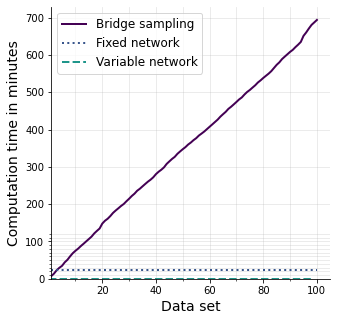

In [27]:
plot_computation_times(bridge_time, NN_fixed_time, np.repeat(0,100), save=True)

In [25]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(np.where(bridge_time > NN_fixed_time)[0][0]+1) # +1 as numpy uses 0-based indexing

3


# Plots for EMPG

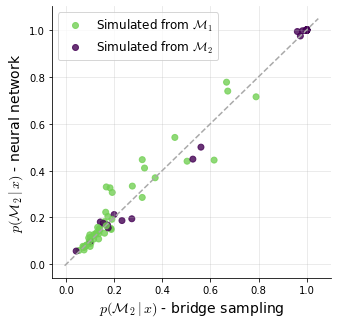

In [26]:
# PMPs (for EMPG)
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', NN_name='neural network', save=True)

In [28]:
from src.python.settings import plotting_settings

def plot_computation_times_empg(bridge_time, NN_fixed_time, save=False):
    """ Plots computation times for bridge sampling and the neural networks."""

    f, ax = plt.subplots(1, 1, figsize=plotting_settings['figsize'])

    ax.plot(bridge_time, label='Bridge sampling', lw=2, color=plotting_settings['colors_discrete'][0])
    ax.plot(NN_fixed_time, label='Neural network', lw=2, linestyle='dotted', color=plotting_settings['colors_discrete'][1])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Data set', fontsize=plotting_settings['fontsize_labels']) # add (cumulative)? 
    ax.set_ylabel('Computation time in minutes', fontsize=plotting_settings['fontsize_labels'])
    ax.set_xlim(xmin=1)
    ax.set_ylim(ymin=0)
    ax.legend(loc='upper left', fontsize=12)

    # Add a grid for every 10 minutes / datasets
    minor_xticks = np.arange(10, 101, 10)
    minor_yticks = np.arange(0, 121, 10)
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(minor_yticks, minor=True)
    ax.grid(which='both', alpha=.3)

    if save:
        plt.savefig('bs_comparison_comp_times.png', dpi=300, bbox_inches='tight')

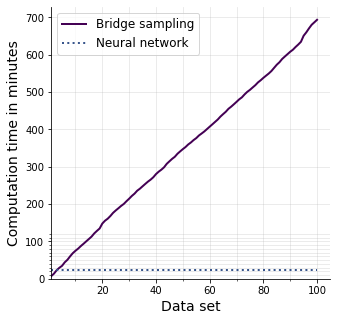

In [29]:
plot_computation_times_empg(bridge_time, NN_fixed_time, save=True)